# CESM2-LE Initial Condition Memory:  Demonstrate how to regrid POP 2D SST to regular lat/lon

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dask Cluster

In [20]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/work/yeager/miniconda3/envs/cesm2

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(5) 

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [3]:
cluster

In [3]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmSST.nc'
if (exists(pp_datafile)):
        print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmSST.nc already exists.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Data Intake

In [4]:
# Point to the catalog file
#catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
catalog_file = '/glade/work/mgrover/intake-esm-catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

# Find POP assets
oceandata = col.search(component='ocn', variable=['TEMP'], frequency='month_1', experiment=['historical','ssp370'])

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
oceandata.df = oceandata.df.sort_values(by=['time_range'])

In [7]:
oceandata.search(cesm_member_id=1231.005).df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
1,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1860-01,1869-12,186001-186912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
2,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1870-01,1879-12,187001-187912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
3,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1880-01,1889-12,188001-188912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
4,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1890-01,1899-12,189001-189912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
5,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1900-01,1909-12,190001-190912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
6,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1910-01,1919-12,191001-191912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
7,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1920-01,1929-12,192001-192912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
8,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1930-01,1939-12,193001-193912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
9,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1940-01,1949-12,194001-194912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1


In [8]:
## Use preprocessor to return annual mean SST
def preproc(ds):
    ds = calc.center_time(ds.isel(z_t=0))
    ds_ann = ds.groupby('time.year').mean().rename({'year':'time'})
    ds_ann.TEMP.attrs = ds.TEMP.attrs
    return ds_ann

In [9]:
%%time
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 35s, sys: 3.09 s, total: 1min 38s
Wall time: 2min 51s


In [10]:
dsets.keys()

dict_keys(['ocn.historical.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.smbb.TEMP', 'ocn.ssp370.pop.h.cmip6.TEMP', 'ocn.ssp370.pop.h.smbb.TEMP'])

In [11]:
dsets['ocn.ssp370.pop.h.smbb.TEMP'].TEMP

<xarray.DataArray 'TEMP' (member_id: 50, time: 86, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(50, 86, 384, 320), dtype=float32, chunksize=(1, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    z_t        float32 500.0
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) <U12 'r10i1191p1f2' 'r11i1231p1f2' ... 'r9i1171p1f2'
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

## Data Processing

#### Prepare for Regridding:

In [12]:
import xesmf as xe
woa1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1.0)),
                     'lon': (['lon'], np.arange(0.5, 360.5, 1.0)),
                    'mask': (['lat','lon'],np.ones((180, 360)))})

In [16]:
%%time
tmp = dsets['ocn.ssp370.pop.h.smbb.TEMP'].TEMP.isel(member_id=0,time=0).drop(['ULAT','ULONG']).load()
regrid_pop = xe.Regridder(tmp, woa1x1, method='bilinear',periodic=True)

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 4.53 s, sys: 148 ms, total: 4.68 s
Wall time: 20.9 s


#### Compute Regridded SST:

In [17]:
%%time
ds = dsets['ocn.historical.pop.h.cmip6.TEMP']
cmip6hist_sst1x1 = regrid_pop(ds.TEMP,keep_attrs=True).persist()

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


CPU times: user 11.4 s, sys: 134 ms, total: 11.5 s
Wall time: 11.9 s


<a id='section2'></a>

In [18]:
cmip6hist_sst1x1

,Array,Chunk
Bytes,4.85 GiB,506.25 kiB
Shape,"(50, 201, 180, 360)","(1, 1, 180, 360)"
Count,10050 Tasks,10050 Chunks
Type,float64,numpy.ndarray


CPU times: user 209 ms, sys: 77.2 ms, total: 286 ms
Wall time: 298 ms


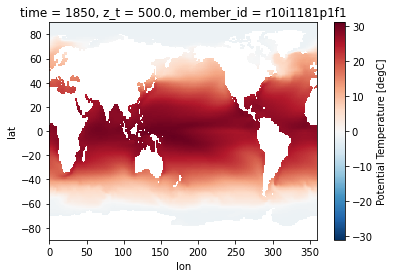

In [19]:
%%time
cmip6hist_sst1x1.isel(member_id=0,time=0).plot();